In [1]:
%load_ext autoreload
%autoreload 2
import features
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
train, test, train_labels, specs = features.read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns


In [3]:
train.installation_id.unique().size

17000

In [4]:
train.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world'],
      dtype='object')

In [5]:
train_labels.columns

Index(['game_session', 'installation_id', 'title', 'num_correct',
       'num_incorrect', 'accuracy', 'accuracy_group'],
      dtype='object')

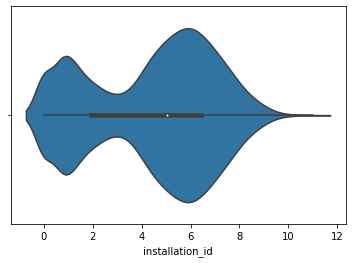

In [6]:
sns.violinplot(np.log(train.installation_id.value_counts()))

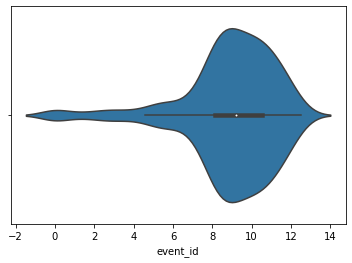

In [7]:
sns.violinplot(np.log(train.event_id.value_counts()))

In [8]:
def get_worst_score(group):
    return group.sort_values('accuracy_group').iloc[0]

labels = train_labels.groupby(['installation_id', 'title']).apply(get_worst_score).reset_index(drop=True)

In [49]:
feats = features.get_basic_user_features(train, labels)

In [52]:
feats['game_time'] = feats['game_time'] / 1000

In [53]:
feats.shape

(9386, 18)

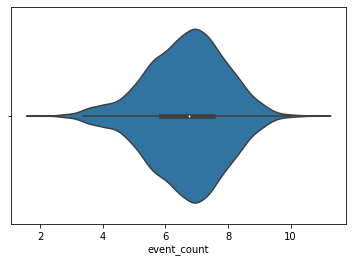

In [54]:
sns.violinplot(np.log(feats.event_count))

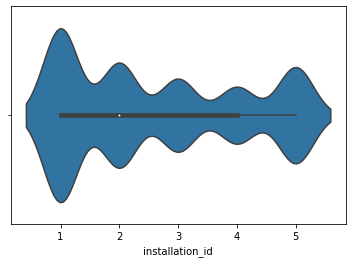

In [55]:
sns.violinplot(feats.installation_id.value_counts())

In [56]:
feats.to_csv('installation_features.csv', index=False)

In [18]:
feats.head()

,installation_id,game_session_y,event_count,game_time,num_unique_days,elapsed_days,last_world,unique_game_sessions,title_y,num_correct,num_incorrect,accuracy,accuracy_group,activity_ct,game_ct,assessment_ct,clip_ct
0,0006a69f,77b8ee947eb84b4e,80570,75295894,1,0 days,TREETOPCITY,26,Bird Measurer (Assessment),0,11,0.0,0,556.0,525.0,135.0,14.0
1,0006a69f,9501794defd84e4d,135226,196920049,1,0 days,TREETOPCITY,48,Mushroom Sorter (Assessment),1,1,0.5,2,1103.0,845.0,229.0,24.0
2,0006c192,197a373a77101924,141995,140663742,2,1 days,MAGMAPEAK,26,Cauldron Filler (Assessment),1,0,1.0,3,894.0,633.0,24.0,15.0
3,0006c192,957406a905d59afd,195450,201045937,4,18 days,TREETOPCITY,48,Bird Measurer (Assessment),1,1,0.5,2,1206.0,643.0,343.0,30.0
4,0006c192,b2297d292892745a,175327,179033827,4,18 days,TREETOPCITY,44,Mushroom Sorter (Assessment),0,4,0.0,0,1206.0,637.0,143.0,28.0


In [57]:
feats.columns

Index(['installation_id', 'game_session_y', 'event_count', 'game_time',
       'num_unique_days', 'elapsed_days', 'last_world', 'last_game_session',
       'unique_game_sessions', 'title_y', 'num_correct', 'num_incorrect',
       'accuracy', 'accuracy_group', 'activity_ct', 'game_ct', 'assessment_ct',
       'clip_ct'],
      dtype='object')

In [62]:
labels_df = feats[['title_y', 'num_correct', 'num_incorrect',
       'accuracy', 'accuracy_group', 'installation_id', 'game_session_y']].copy()
feats_df = feats.drop(['title_y', 'num_correct', 'num_incorrect', 'installation_id', 'game_session_y', 'last_game_session',
       'accuracy', 'accuracy_group'], axis=1)

In [65]:
feats_df['elapsed_days'] = feats_df.elapsed_days.dt.days

In [84]:
feats_arrays = [row[1].fillna(0) for row in feats_df.iterrows()]

In [88]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [82]:
feats_arrays[:100]

[event_count                    1230
 game_time                   1135.91
 num_unique_days                   1
 elapsed_days                      0
 last_world              TREETOPCITY
 unique_game_sessions             26
 activity_ct                     556
 game_ct                         525
 assessment_ct                   135
 clip_ct                          14
 Name: 0, dtype: object, event_count                    2201
 game_time                   3488.07
 num_unique_days                   1
 elapsed_days                      0
 last_world              TREETOPCITY
 unique_game_sessions             48
 activity_ct                    1103
 game_ct                         845
 assessment_ct                   229
 clip_ct                          24
 Name: 1, dtype: object, event_count                  1566
 game_time                 1342.99
 num_unique_days                 2
 elapsed_days                    1
 last_world              MAGMAPEAK
 unique_game_sessions           26
 a

In [85]:
OneHot = OneHotEncoder()
train_vectors = OneHot.fit_transform(feats_arrays)

In [94]:
cv = GridSearchCV(LogisticRegression(), scoring='accuracy', param_grid={'C': [10**i for i in range(-3, 3)], 'max_iter': [1000]})
cv.fit(train_vectors, labels_df.accuracy_group)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [95]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.185809,0.004434,0.001102,0.000012,0.001,1000,"{'C': 0.001, 'max_iter': 1000}",0.436635,0.441129,0.438466,0.437400,0.430474,0.436821,0.003519,3
1,0.362119,0.003229,0.001061,0.000146,0.01,1000,"{'C': 0.01, 'max_iter': 1000}",0.454739,0.455514,0.459243,0.442728,0.458711,0.454187,0.005990,2
2,0.956328,0.038472,0.001259,0.000088,0.1,1000,"{'C': 0.1, 'max_iter': 1000}",0.463791,0.459243,0.463506,0.449654,0.451785,0.457596,0.005880,1
3,2.338594,0.051709,0.001201,0.000072,1,1000,"{'C': 1, 'max_iter': 1000}",0.427050,0.412360,0.434736,0.416622,0.425147,0.423183,0.007905,4
4,4.119566,0.176430,0.001187,0.000020,10,1000,"{'C': 10, 'max_iter': 1000}",0.414803,0.400639,0.418753,0.394246,0.404369,0.406562,0.009035,5
5,5.797235,0.123899,0.001151,0.000123,100,1000,"{'C': 100, 'max_iter': 1000}",0.402023,0.393713,0.413958,0.394779,0.406500,0.402195,0.007535,6
